<a href="https://colab.research.google.com/github/tmiessa/mdc-defaultcredit/blob/development/mdc_defaultcredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDC 2019 - INF-0619 - Default of Credit Cards


## Alunos
* Matheus Pacheco
* Raphael Santos
* Renato Dias
* Tiago Miessa

## Setup Inicial

### Imports

In [0]:
import sys
import os 
import requests
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample

from xgboost import XGBClassifier


sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Carregamento do Dataset

In [0]:
## download files
if os.path.isfile('UCI_Credit_Card.csv'):
    print('file already exists!')
else:
    print('file does not exists, downloading...')
    myfile = requests.get('https://onedrive.live.com/download?cid=F1E435813B40678A&resid=F1E435813B40678A%218086&authkey=AE0BdkzcP5BTU-M')
    open('UCI_Credit_Card.csv', 'wb').write(myfile.content)
    print('file downloaded')

file already exists!


In [0]:
df = pd.read_csv('UCI_Credit_Card.csv')

# Rename de coluna fora do padrão e do target, para facilitar referência futura
df.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'DEFAULTED'}, inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULTED
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Divisão do Dataset entre Treino / Validação / Teste

Os conjuntos serão divididos na seguinte proporção, de forma estratificada:
- 80% Treino
- 10% Validação
- 10% Teste

In [0]:
test_size_split = 0.2
random_seed_val = 757913

In [0]:
paymentFields = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
ownedFields = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

# Campo ID será ignorado, por ser chave única
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1], df.iloc[:,-1], stratify=df.iloc[:,-1], test_size=test_size_split, random_state=random_seed_val)
x_test, x_valid, y_test, y_valid = train_test_split(x_test,y_test, test_size=0.5, stratify=y_test, random_state=random_seed_val+1)

In [0]:
print(df.shape,
      x_train.shape,
      x_valid.shape,
      x_test.shape)

(30000, 25) (24000, 23) (3000, 23) (3000, 23)


## Análise Exploratória Inicial

### Verificação de características das Features

In [0]:
df[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,30000.000000,30000.000000
mean,167484.322667,35.485500
std,129747.661567,9.217904
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,1000000.000000,79.000000


A feature `LIMIT_BAL`, que indica o limite de crédito do cartão, varia de 10.000 a 1.000.000 NT Dólares, e a idade varia de 21 a 79 anos.


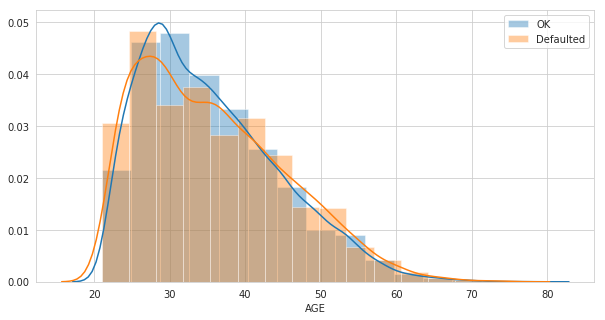

In [0]:
plt.figure(figsize=(10,5))
sns.distplot(df[df.DEFAULTED==0]['AGE'], bins=15, label='OK')
sns.distplot(df[df.DEFAULTED==1]['AGE'], bins=15, label='Defaulted')
p=plt.legend()

Podemos observar que há uma tendencia maior de calote até os 25 anos e após os 45 (Iremos utilizar esta informação na seção de Feature Engineering).

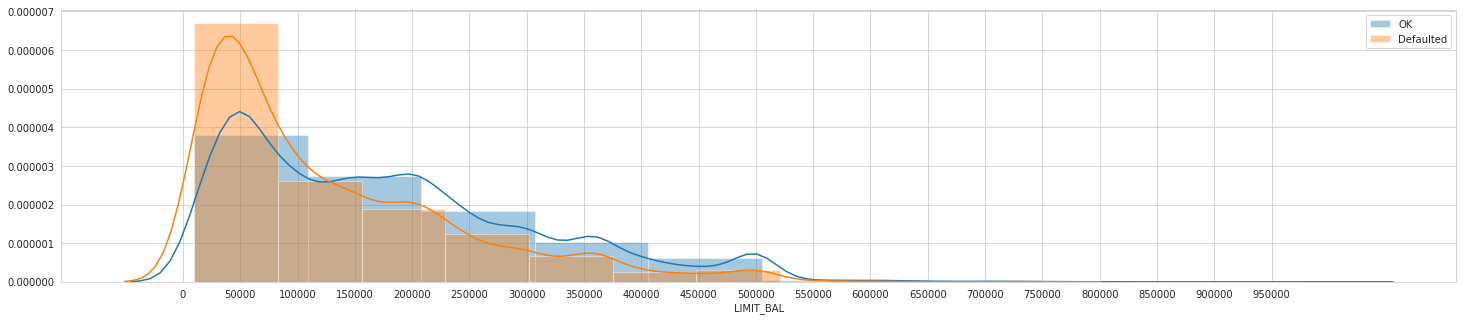

In [0]:
plt.figure(figsize=(25,5))
sns.distplot(df[df.DEFAULTED==0]['LIMIT_BAL'], bins=10, label='OK')
sns.distplot(df[df.DEFAULTED==1]['LIMIT_BAL'], bins=10, label='Defaulted')
plt.legend()
p=plt.xticks(range(0,1000000,50000))

Da mesma forma que com a idade, vemos uma tendencia maior de calote para quem tem o limite abaixo de 125k.

In [0]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [0]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(pd.Series.value_counts).fillna(0).astype(int)

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
-2,2759,3782,4085,4348,4546,4895
-1,5686,6050,5938,5687,5539,5740
0,14737,15730,15764,16455,16947,16286
1,3688,28,4,2,0,0
2,2667,3927,3819,3159,2626,2766
3,322,326,240,180,178,184
4,76,99,76,69,84,49
5,26,25,21,35,17,13
6,11,12,23,5,4,19
7,9,20,27,58,58,46


**Features PAY_X**

As features `PAY_X` indicam o pagamento dos meses de Setembro de 2005 a Abril 2005, onde podem assumir os seguintes valores:

* **`-1:`** pago devidamente
* **`1:`** atraso no pagamento de 1 mês
* **`2:`** atraso no pagamento de 2 meses
* **`X:`** atraso no pagamento de X meses (limite superior = 9)

**Problemas encontrados:**

*   Valores -2 e 0, sem documentação





In [0]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


**Features BILL_AMTX**

As features `BILL_AMTX` indicam o valor da fatura do cartão de crédito nos meses de Setembro 2005 (BILL_AMT1) a Abril 2005 (BILL_AMT6)

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.

In [0]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [0]:
df[['SEX','EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [0]:
df[['SEX','EDUCATION', 'MARRIAGE']].apply(pd.Series.value_counts).fillna(0).astype(int)

,SEX,EDUCATION,MARRIAGE
0,0,14,54
1,11888,10585,13659
2,18112,14030,15964
3,0,4917,323
4,0,123,0
5,0,280,0
6,0,51,0


**Features SEX, EDUCATION e MARRIAGE**

* **`SEX:`** indica o gênero do cliente (1: masculino, 2: feminino)
* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)
* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)
* Valores não documentados para **`MARRIAGE`** (0)

SEX
1    0.241672
2    0.207763
Name: DEFAULTED, dtype: float64

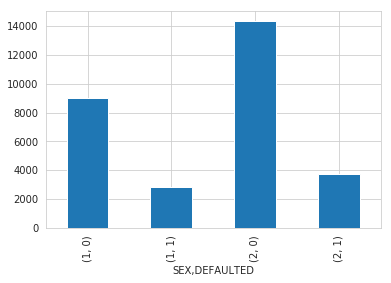

In [0]:
test = df['DEFAULTED'].groupby(df['SEX'])
p=test.value_counts().plot(kind='bar')

test.mean()

Podemos ver que há mais homens no conjunto e que eles tendem a dar calote com mais frequência, na média

EDUCATION
0    0.000000
1    0.192348
2    0.237349
3    0.251576
4    0.056911
5    0.064286
6    0.156863
Name: DEFAULTED, dtype: float64

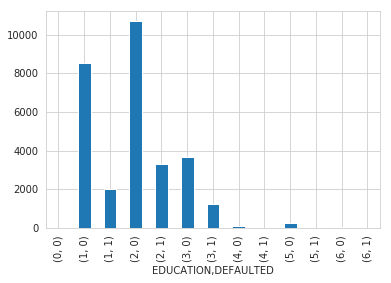

In [0]:
test = df['DEFAULTED'].groupby(df['EDUCATION'])
p=test.value_counts().plot(kind='bar')

test.mean()

###Distribuição dos Dados

Podemos observar que há um desbalanceamento entre as duas classes:

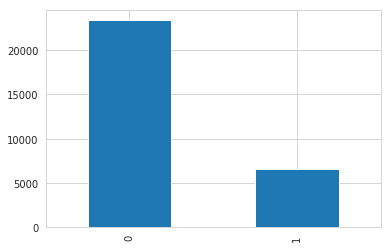

In [0]:
df['DEFAULTED'].value_counts().plot(kind='bar');

Fizemos uma redução de dimensionalidade (utilizando  T-SNE) para conseguir visualizar a distribuição das features. Infelizmente, não conseguimos observar uma divisão clara entre os dois conjuntos apenas dessa forma:

In [0]:
%%time

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_valid = encoder2D.fit_transform(x_valid)

CPU times: user 4min 56s, sys: 957 ms, total: 4min 57s
Wall time: 4min 57s


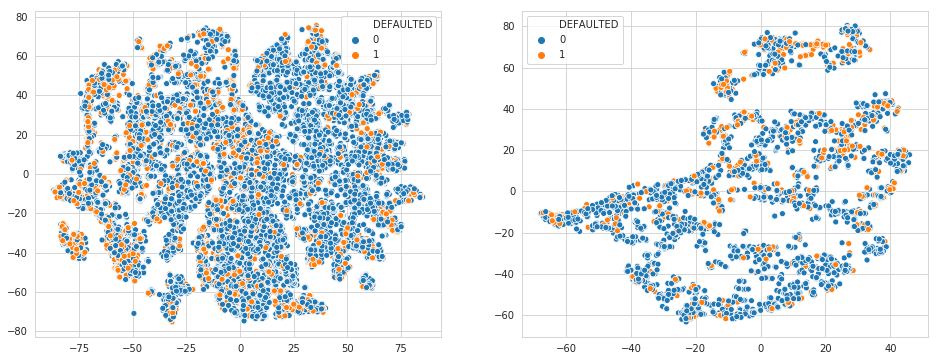

In [0]:
plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette(n_colors=2)

for ix, (x, y) in enumerate(((w_train, y_train), (w_valid, y_valid))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

### Pivotamento (para análise futura)

Para facilitar a análise de evolução no tempo das colunas PAY_N, BILL_AMTN e PAY_AMTN, definimos o método abaixo para fazer o pivotamento das informações:

In [0]:
def pivotAgg(row1):
    res = np.concatenate( ( 
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1','BILL_AMT1','PAY_AMT1','DEFAULTED']].append(pd.Series({'DATE':date(2005,9,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2','BILL_AMT2','PAY_AMT2','DEFAULTED']].append(pd.Series({'DATE':date(2005,8,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_3','BILL_AMT3','PAY_AMT3','DEFAULTED']].append(pd.Series({'DATE':date(2005,7,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_4','BILL_AMT4','PAY_AMT4','DEFAULTED']].append(pd.Series({'DATE':date(2005,6,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_5','BILL_AMT5','PAY_AMT5','DEFAULTED']].append(pd.Series({'DATE':date(2005,5,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_6','BILL_AMT6','PAY_AMT6','DEFAULTED']].append(pd.Series({'DATE':date(2005,4,1)}))]
    ))
    return res

# Outra ideia a ser explorada: usar o melt para cada coluna alvo, ao invés de todas de uma vez (value_vars not set: everything else)
# test = df.melt(id_vars=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])
# test.reset_index(drop=True,inplace=True)
# test.head()

In [0]:
pdf = pd.DataFrame(np.concatenate([ pivotAgg(row[1]) for row in df.iterrows()]))
pdf.columns = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAYMENT STATUS','BILL AMOUNT','PAID AMOUNT','DEFAULTED', 'DATE']
pdf.to_csv('UCI_Credit_Card_Pivoted.csv', index=False)

Um ponto interessante é que neste Dataset há uma diferença considerável entre o que é esperado e o que foi pago com os clientes - a proporção para os 4 meses é de cerca de 12%:

In [0]:
round(100 * (pdf['PAID AMOUNT'].sum()/pdf['BILL AMOUNT'].sum()))

12

Isso pode indicar que o DataSet é composto na maioria por clientes problemáticos, ou que o banco possa estar na iminência de decretar falência.

## Construção do Baseline

Serão construídos alguns modelos para verificação da acurácia antes que qualquer pré-processamento (com exceção de normalização) seja feito nos dados. O motivo para isso é que o problema pode estar na descrição, ao invés de no conjunto.

In [0]:
scaler = StandardScaler()

z_train = scaler.fit_transform(x_train)
z_valid = scaler.transform(x_valid)

In [0]:
def plotResults(title, predictions, y_valid):
    print(title)
    print('Accuracy: %.2f%%' % (accuracy_score(y_valid, predictions)*100))
    print('F1 Score: %.2f%%' % (f1_score(y_valid, predictions)*100))
    print('Balanced Accuracy: %.2f%%\n' % (balanced_accuracy_score(y_valid, predictions)*100))

    c = confusion_matrix(y_valid, predictions)
    r = c / c.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7, 5))
    # Matriz de Confusão:
    # 	Linhas: Real
    # 	Colunas: Predito
    sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%', vmin=0.1, vmax=1.0);
#   plt.title(title)
    plt.ylabel("Valores Reais")
    plt.xlabel("Valores Preditos")

### Regressão Logística

In [0]:
%%time
## logistic regression
# logreg = LogisticRegression(random_state=42, class_weight='balanced').fit(x_train, y_train)
# y_pred = logreg.predict(x_valid)
logreg = LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced').fit(z_train, y_train)
predictions = logreg.predict(z_valid)


CPU times: user 229 ms, sys: 119 ms, total: 348 ms
Wall time: 185 ms


Regressão Logística
Accuracy: 69.23%
F1 Score: 48.12%
Balanced Accuracy: 67.56%



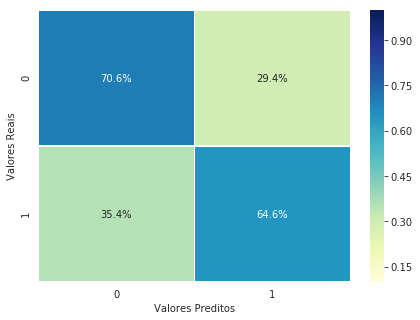

In [0]:
plotResults('Regressão Logística', predictions, y_valid)

### SVM

Treinado com todos os valores padrão, com exceção do peso das classes, que foi definido como 'balanced' (para amenizar a diferença entre a distribuição das classes)

In [0]:
%%time

svm = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced', random_state=999)
svm.fit(z_train, y_train)
predictions = svm.predict(z_valid)

CPU times: user 46.4 s, sys: 155 ms, total: 46.6 s
Wall time: 46.6 s


SVM - Baseline
Accuracy: 77.03%
F1 Score: 52.90%
Balanced Accuracy: 70.35%



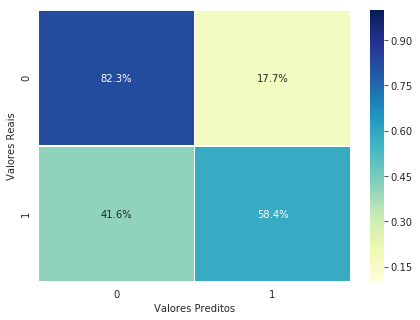

In [0]:
plotResults('SVM - Baseline', predictions, y_valid)

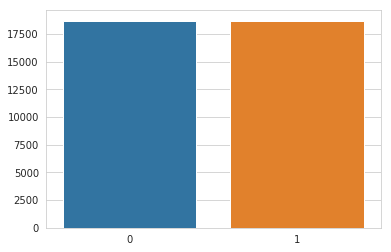

In [0]:
# Dados estão desbalanceados - usar um SMOTE ajudaria?
# Para o SVM provavelmente não, por conta de toda a ideia por trás dele. Mas checaremos de qualquer maneira, para ter certeza

smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoter.fit_resample(z_train, y_train)

defaultedS = np.unique(sy_train, return_counts=True)
sns.barplot(defaultedS[0],defaultedS[1])

In [0]:
%%time

svmS = SVC(kernel='rbf', C=1, gamma='auto', random_state=999)
svmS.fit(sz_train, sy_train)
predictions = svmS.predict(z_valid)

CPU times: user 1min 23s, sys: 130 ms, total: 1min 23s
Wall time: 1min 23s


SVM - Baseline & SMOTE
Accuracy: 77.80%
F1 Score: 53.16%
Balanced Accuracy: 70.36%



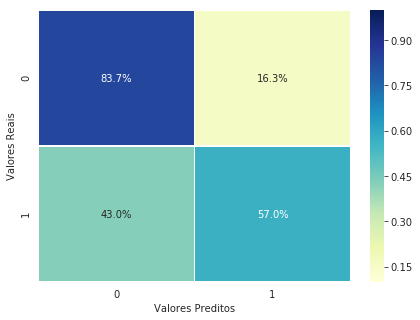

In [0]:
plotResults('SVM - Baseline & SMOTE', predictions, y_valid)

### MLP

In [0]:
from sklearn.utils import class_weight

bcw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(bcw))
np.round(bcw,2)

array([0.64, 2.26])

In [0]:
# Fonte: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric

# import tensorflow as tf

# def f1(y_true, y_pred):
#     y_pred = K.round(y_pred)
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return K.mean(f1)

# def f1_loss(y_true, y_pred):
    
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return 1 - K.mean(f1)

In [0]:

from keras import models
from keras import layers
from keras import regularizers
from keras import backend as K

penalty=1

model = models.Sequential()
model.add(layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(penalty), input_shape=(z_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# model.add(layers.Dense(32, activation='sigmoid' , kernel_regularizer=regularizers.l2(penalty) ))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(6, activation='relu' , kernel_regularizer=regularizers.l2(penalty) ))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='sgd', loss='mse', metrics=['binary_accuracy'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
#model.compile(optimizer='rmsprop', loss=f1_loss, metrics=['binary_accuracy', f1])

model.summary()

Using TensorFlow backend.
W0823 22:01:19.445439 140508260833152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 22:01:19.460250 140508260833152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 22:01:19.463275 140508260833152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 22:01:19.540325 140508260833152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12)                48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 349
Trainable params: 325
Non-trainable params: 24
_________________________________________________________________


In [0]:
%%time

model.fit(z_train, y_train, validation_data=(z_valid, y_valid), batch_size=32, epochs=8, class_weight=class_weights)
predictions = model.predict_classes(z_valid)

Train on 24000 samples, validate on 3000 samples
Epoch 1/8
24000/24000 [==============================] - 1s 56us/step - loss: 3.0913 - binary_accuracy: 0.5942 - val_loss: 0.6038 - val_binary_accuracy: 0.7773
Epoch 2/8
24000/24000 [==============================] - 1s 41us/step - loss: 0.6324 - binary_accuracy: 0.7181 - val_loss: 0.6047 - val_binary_accuracy: 0.7727
Epoch 3/8
24000/24000 [==============================] - 1s 41us/step - loss: 0.6316 - binary_accuracy: 0.7167 - val_loss: 0.5831 - val_binary_accuracy: 0.7720
Epoch 4/8
24000/24000 [==============================] - 1s 42us/step - loss: 0.6318 - binary_accuracy: 0.7292 - val_loss: 0.5904 - val_binary_accuracy: 0.7653
Epoch 5/8
24000/24000 [==============================] - 1s 41us/step - loss: 0.6292 - binary_accuracy: 0.7261 - val_loss: 0.6006 - val_binary_accuracy: 0.7763
Epoch 6/8
24000/24000 [==============================] - 1s 42us/step - loss: 0.6278 - binary_accuracy: 0.7291 - val_loss: 0.6248 - val_binary_accuracy

MLP - Baseline
Accuracy: 72.87%
F1 Score: 47.82%
Balanced Accuracy: 66.92%



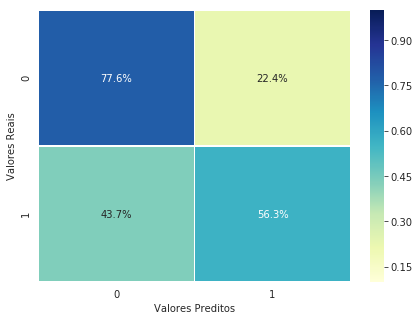

In [0]:
plotResults('MLP - Baseline', predictions, y_valid)

## Análise Aprofundada dos Dados

### Limpeza dos dados

#### **Features BILL_AMTX**

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.


In [0]:
df[(df.BILL_AMT1 < 0) & (df.BILL_AMT2 <0)].head(5)[ ['ID'] + paymentFields + ownedFields]

,ID,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
26,27,0.0,1000.0,0.0,500.0,0.0,1000.0,-109.0,-425.0,259.0,-57.0,127.0,-189.0
68,69,0.0,0.0,20161.0,0.0,7319.0,13899.0,-190.0,-9850.0,-9850.0,10311.0,10161.0,7319.0
101,102,223.0,33178.0,1171.0,1197.0,1250.0,5000.0,-81.0,-303.0,32475.0,32891.0,33564.0,34056.0
109,110,0.0,0.0,0.0,0.0,0.0,0.0,-103.0,-103.0,-103.0,-103.0,-103.0,-103.0
149,150,0.0,22500.0,0.0,969.0,1000.0,0.0,-1100.0,-1100.0,21400.0,0.0,969.0,869.0



Esses valores fazem sentido em um contexto onde o cliente pagou mais do que deveria em um mês.  Dessa forma, não faremos nenhuma alteração nesta _Feature_.

#### Feature EDUCATION

* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)


In [0]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

É possível que haja um problema na descrição do Dataset, mas como temos um valor "Others", iremos testar trocar os valores desconhecidos por ele. e rodar um dos modelos de baseline novamente:

In [0]:
x_train.EDUCATION[x_train.EDUCATION.isin([0,5,6])] = 4
x_valid.EDUCATION[x_valid.EDUCATION.isin([0,5,6])] = 4

edu_scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_valid = scaler.transform(x_valid)


In [0]:
svmEdu = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmEdu.fit(z_train, y_train)

predictions = svmEdu.predict(z_valid)

SVM - Ajuste EDUCATION
Accuracy: 77.23%
F1 Score: 52.73%
Balanced Accuracy: 70.15%



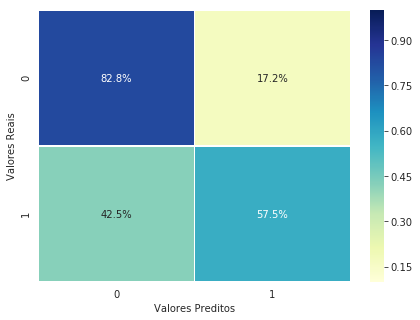

In [0]:
plotResults('SVM - Ajuste EDUCATION', predictions, y_valid)

A diferença não foi significativa, então manteremos este ajuste daqui em diante.

#### Feature MARRIAGE

* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`MARRIAGE`** (0)

In [0]:
df.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [0]:
x_train.EDUCATION[x_train.EDUCATION.isin([0])] = 3
x_valid.EDUCATION[x_valid.EDUCATION.isin([0])] = 3

mar_scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_valid = scaler.transform(x_valid)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
svmMAR = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmMAR.fit(z_train, y_train)
predictions = svmMAR.predict(z_valid)

SVM - Ajuste MARRIAGE
Accuracy: 77.23%
F1 Score: 52.73%
Balanced Accuracy: 70.15%



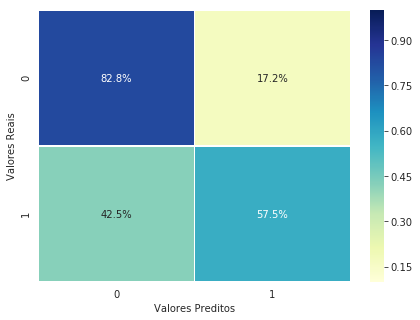

In [0]:
plotResults('SVM - Ajuste MARRIAGE', predictions, y_valid)

Para a feature Marriage, a alteração dos valores não teve efeito notável. Dessa forma, iremos manter a alteração para deixar o Dataset mais próximo dos valores esperados de acordo com a descrição.

### Feature Selection

 - Análise de correlação
 - Análise de importância das features para um classificador de árvore (GBM)

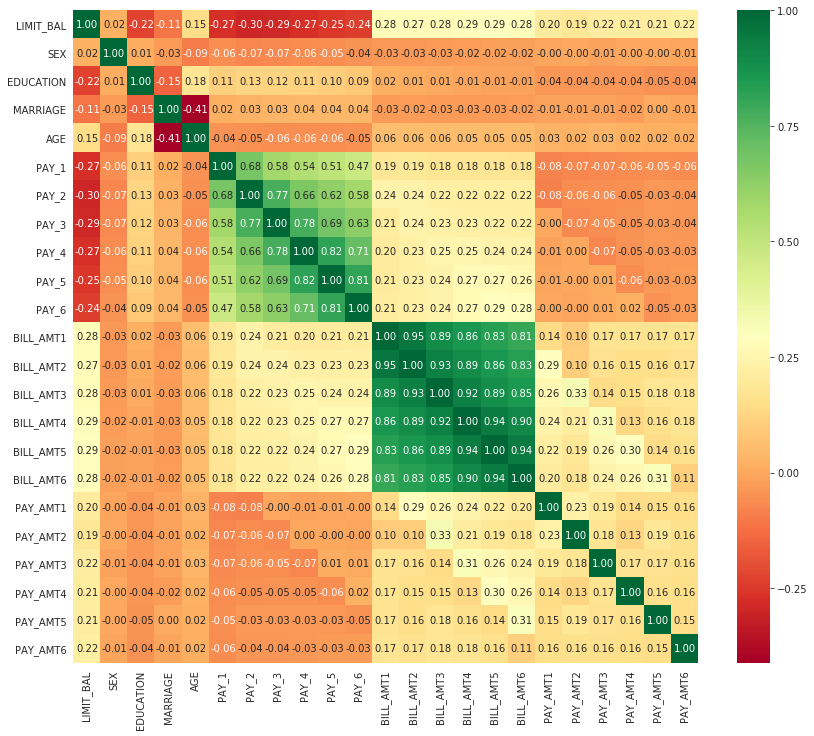

In [0]:
corrmat = x_train.corr()
top_corr_features = corrmat.index
#plot heat map
plt.figure(figsize=(14,12))
g=sns.heatmap(x_train[top_corr_features].corr(), annot=True, cmap="RdYlGn", fmt='.2f')

In [0]:
gbm = GradientBoostingClassifier()
sz_train, sy_train = smoter.fit_resample(z_train, y_train)

gbm.fit(sz_train, sy_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GBM - Baseline
Accuracy: 79.63%
F1 Score: 52.60%
Balanced Accuracy: 69.43%



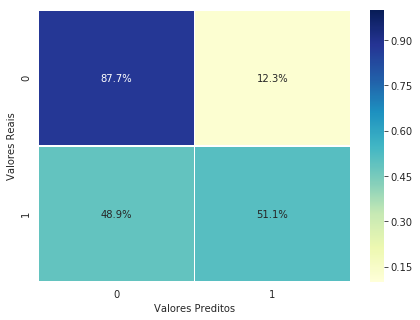

In [0]:
predictions = gbm.predict(z_valid)
plotResults('GBM - Baseline', predictions, y_valid)

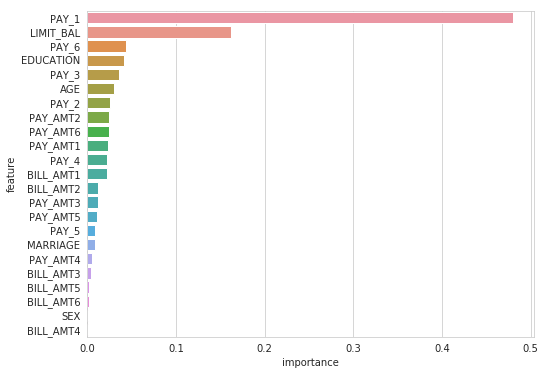

In [0]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbm.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)


Considerações:
- As features referentes ao total das contas possuem alta correlação entre si
- Selecionamos com base nas features mais relevantes para o GBM um subconjunto para treinar um novo classificador SVM e comparar o resultado (sem utilizar SMOTE, já que não houve diferença significativa no teste anterior)

In [0]:
fx_train = x_train.loc[:,['EDUCATION','AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1','PAY_AMT6']]
fx_valid = x_valid.loc[:,['EDUCATION','AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1','PAY_AMT6']]

scaler2 = StandardScaler()

fz_train = scaler2.fit_transform(fx_train)
fz_valid = scaler2.transform(fx_valid)

SVM - SVC Redux
Accuracy: 77.13%
F1 Score: 53.33%
Balanced Accuracy: 70.68%



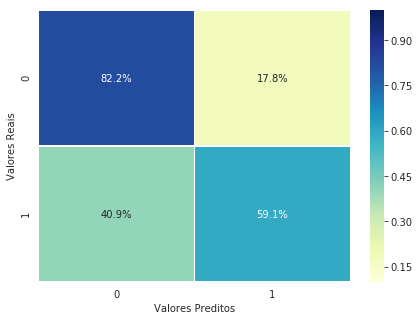

In [0]:
svm2 = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=979979)
svm2.fit(fz_train, y_train)

predictions = svm2.predict(fz_valid)

plotResults('SVM - SVC Redux', predictions, y_valid)

### Feature Engineering


#### Criação de features


Um detalhe que pode ser interessante para ajudar na predição é a porcentagem de quanto foi pago sobre o que era devido. Iremos adicionar essa feature e testar o resultado.

Iremos utilizar os valores corrigidos no passo anterior, uma vez que não houve mudança significativa nos indicadores analisados com o uso restrito as features mais significativas.


In [0]:

# Somando +1 para evitar campos com zero
fx_train.insert(1,'PPAID', ((x_train[paymentFields].sum(axis=1)+1) / (x_train[ownedFields].sum(axis=1)+1)) )
fx_valid.insert(1,'PPAID', ((x_valid[paymentFields].sum(axis=1)+1) / (x_valid[ownedFields].sum(axis=1)+1)) )

scalerPP = StandardScaler()
fz_train = scalerPP.fit_transform(fx_train)
fz_valid = scalerPP.transform(fx_valid)

In [0]:
fx_train.head(3)

,EDUCATION,PPAID,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT6
13018,2,0.293205,27,200000.0,0,0,0,0,0,0,4013.0,39777.0
1970,1,0.437699,42,200000.0,0,-1,0,0,-1,-1,19067.0,326.0
6377,3,0.494666,26,30000.0,0,0,0,0,-1,-1,2595.0,0.0


In [0]:
svmPP = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=666)
svmPP.fit(fz_train, y_train)
predictions = svmPP.predict(fz_valid)

SVM - Adição % pagamento
Accuracy: 77.13%
F1 Score: 53.14%
Balanced Accuracy: 70.52%



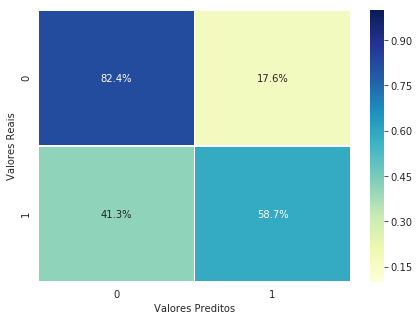

In [0]:
plotResults('SVM - Adição % pagamento', predictions, y_valid)

In [0]:
smoterPP = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoterPP.fit_resample(fz_train, y_train)

In [0]:
gbmPP = GradientBoostingClassifier()
gbmPP.fit(sz_train, sy_train)
predictions = gbmPP.predict(fz_valid)

GBM - Adição % pagamento
Accuracy: 78.90%
F1 Score: 51.86%
Balanced Accuracy: 69.06%



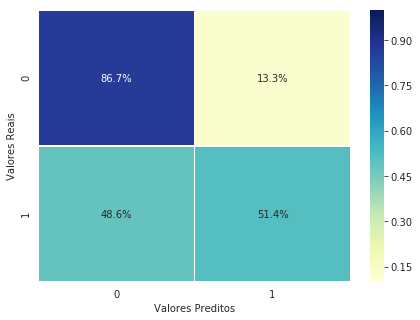

In [0]:
plotResults('GBM - Adição % pagamento', predictions, y_valid)

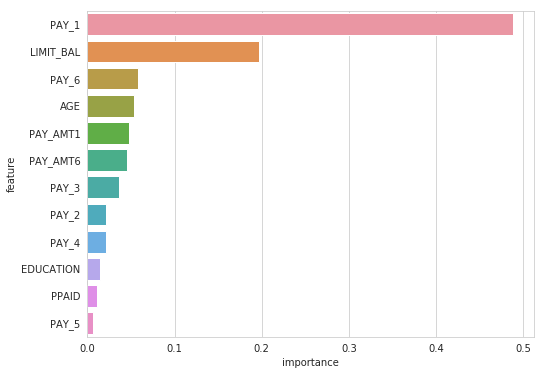

In [0]:
feature_importances = pd.DataFrame({ 'feature': fx_train.columns, 'importance': gbmPP.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance, feature_importances.feature)


Essa feature não fez diferença alguma, próximo teste!

In [0]:
fx_train.drop('PPAID', axis=1, inplace=True)
fx_valid.drop('PPAID', axis=1, inplace=True)

In [0]:
for i in range(1,7):
    fx_train.insert(1, 'BTEMP'+str(i), x_train['BILL_AMT'+str(i)])
    fx_valid.insert(1, 'BTEMP'+str(i), x_valid['BILL_AMT'+str(i)])
    
    fx_train.insert(1, 'PTEMP'+str(i), x_train['PAY_AMT'+str(i)])
    fx_valid.insert(1, 'PTEMP'+str(i), x_valid['PAY_AMT'+str(i)])
    
    # Onde o total é 0, consideraremos 100% pago a dívida do mês
    fx_train['PTEMP'+str(i)][x_train['BILL_AMT'+str(i)] == 0] = 1
    fx_train['BTEMP'+str(i)][x_train['BILL_AMT'+str(i)] == 0] = 1
    
    fx_valid['PTEMP'+str(i)][x_valid['BILL_AMT'+str(i)] == 0] = 1
    fx_valid['BTEMP'+str(i)][x_valid['BILL_AMT'+str(i)] == 0] = 1
    
    fx_train.insert(1,'PPAID'+str(i), fx_train['PTEMP'+str(i)] / fx_train['BTEMP'+str(i)] )
    fx_valid.insert(1,'PPAID'+str(i), fx_valid['PTEMP'+str(i)] / fx_valid['BTEMP'+str(i)] )

# checagem de valores nulos
fx_train.loc[fx_train.index[np.isinf(fx_train).any(1)]].head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher

,EDUCATION,PPAID6,PTEMP6,BTEMP6,PPAID5,PTEMP5,BTEMP5,PPAID4,PTEMP4,BTEMP4,PPAID3,PTEMP3,BTEMP3,PPAID2,PTEMP2,BTEMP2,PPAID1,PTEMP1,BTEMP1,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT6


In [0]:
for i in range(1,7):
    fx_train.drop('BTEMP'+str(i), axis=1, inplace=True)
    fx_train.drop('PTEMP'+str(i), axis=1, inplace=True)
    fx_valid.drop('BTEMP'+str(i), axis=1, inplace=True)
    fx_valid.drop('PTEMP'+str(i), axis=1, inplace=True)

In [0]:
scalerMP = StandardScaler()

mz_train = scalerMP.fit_transform(fx_train)
mz_valid = scalerMP.transform(fx_valid)

In [0]:
smoterMPP = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoterMPP.fit_resample(mz_train, y_train)

In [0]:
gbmMPP = GradientBoostingClassifier()
gbmMPP.fit(sz_train, sy_train)
predictions = gbmMPP.predict(mz_valid)

GBM - média pagamento por cada mês
Accuracy: 78.83%
F1 Score: 51.49%
Balanced Accuracy: 68.80%



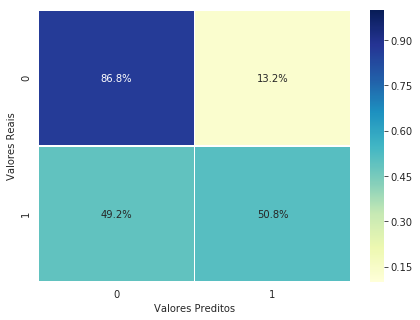

In [0]:
plotResults('GBM - média pagamento por cada mês', predictions, y_valid)

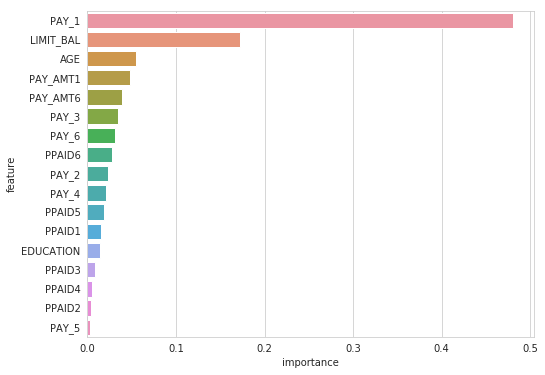

In [0]:
feature_importances = pd.DataFrame({ 'feature': fx_train.columns, 'importance': gbmMPP.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)

Yep.... gigante pilha de .... nada. "PPAID6" até apareceu em uma posição de destaque, mas os dois classificadores treinados não apresentaram melhora significativa na taxa de acerto.

Remoção das features inúteis...

In [0]:
for i in range(1,7):
    fx_train.drop('PPAID'+str(i), axis=1, inplace=True)
    fx_valid.drop('PPAID'+str(i), axis=1, inplace=True)

In [0]:
fx_valid.head(3)

,EDUCATION,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT6
20764,2,46,20000.0,0,0,0,0,0,0,1363.0,0.0
18562,2,25,90000.0,0,0,0,0,0,0,3000.0,2000.0
18255,3,55,80000.0,0,0,0,0,0,0,63000.0,12900.0


Ultima tentativa: medir o total de pagamento no período e dividir pelo limite disponível.

In [0]:
fx_train.insert(1,'PSCORE', (x_train[paymentFields].sum(axis=1)) / x_train['LIMIT_BAL'])
fx_valid.insert(1,'PSCORE', (x_valid[paymentFields].sum(axis=1)) / x_valid['LIMIT_BAL']) 

In [0]:
fx_train.head(2)

,EDUCATION,PSCORE,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT6
13018,2,0.280815,27,200000.0,0,0,0,0,0,0,4013.0,39777.0
1970,1,0.125225,42,200000.0,0,-1,0,0,-1,-1,19067.0,326.0


In [0]:
scalerF = StandardScaler()

mz_train = scalerMP.fit_transform(fx_train)
mz_valid = scalerMP.transform(fx_valid)

smoterF = SMOTE(sampling_strategy = 'minority', random_state=666)
sz_train, sy_train = smoterMPP.fit_resample(mz_train, y_train)

gbmF = GradientBoostingClassifier()
gbmF.fit(sz_train, sy_train)
predictions = gbmF.predict(mz_valid)

GBM - score pagamento por limite
Accuracy: 79.13%
F1 Score: 51.55%
Balanced Accuracy: 68.78%



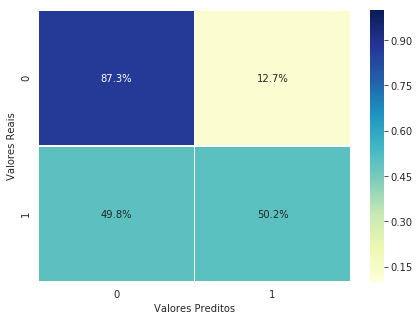

In [0]:
plotResults('GBM - score pagamento por limite', predictions, y_valid)

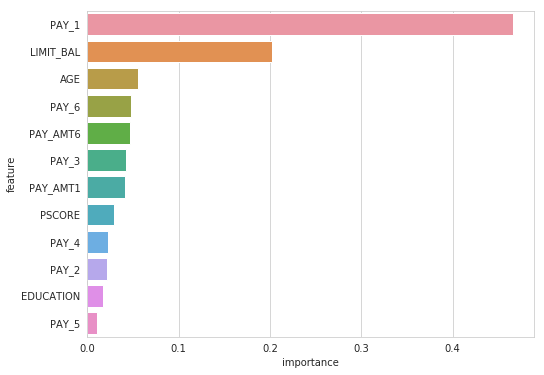

In [0]:
feature_importances = pd.DataFrame({ 'feature': fx_train.columns, 'importance': gbmF.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)

Parece ter ajudado, verificando resultado com um SVM

In [0]:
svmF = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=666)
svmF.fit(mz_train, y_train)
predictions = svmF.predict(mz_valid)

SVM - score pagamento por limite
Accuracy: 77.03%
F1 Score: 52.97%
Balanced Accuracy: 70.40%



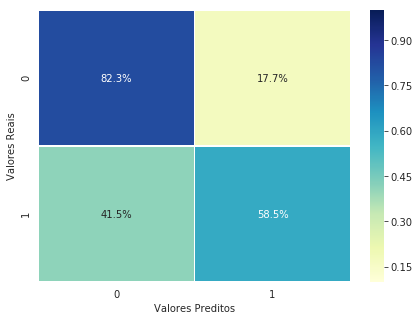

In [0]:
plotResults('SVM - score pagamento por limite', predictions, y_valid)

#### Agrupamento das features categóricas (Binning)

In [0]:
bins = [0, 25, 45, 100]
labels = ['AGE1', 'AGE2', 'AGE3']

fx_train['AGE_GROUP'] = pd.cut(fx_train['AGE'], bins=bins, labels=labels)
fx_valid['AGE_GROUP'] = pd.cut(fx_valid['AGE'], bins=bins, labels=labels)

In [0]:
fx_train.head(3)

,EDUCATION,PSCORE,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT6,AGE_GROUP
13018,2,0.280815,27,200000.0,0,0,0,0,0,0,4013.0,39777.0,AGE2
1970,1,0.125225,42,200000.0,0,-1,0,0,-1,-1,19067.0,326.0,AGE2
6377,3,2.207300,26,30000.0,0,0,0,0,-1,-1,2595.0,0.0,AGE2


In [0]:
bins = [-3,-1,0,9]
labels = ['BOM', 'MEDIO','DEVEDOR']

for i in range(1,7):
    fx_train.insert(i-1,'EPAY'+str(i), pd.cut(fx_train['PAY_'+str(i)], bins=bins, labels=labels) )
    fx_valid.insert(i-1,'EPAY'+str(i), pd.cut(fx_valid['PAY_'+str(i)], bins=bins, labels=labels) )

In [0]:
fx_train.head(5)

,EPAY1,EPAY2,EPAY3,EPAY4,EPAY5,EPAY6,EDUCATION,PSCORE,AGE,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT6,AGE_GROUP
13018,MEDIO,MEDIO,MEDIO,MEDIO,MEDIO,MEDIO,2,0.280815,27,200000.0,0,0,0,0,0,0,4013.0,39777.0,AGE2
1970,MEDIO,BOM,MEDIO,MEDIO,BOM,BOM,1,0.125225,42,200000.0,0,-1,0,0,-1,-1,19067.0,326.0,AGE2
6377,MEDIO,MEDIO,MEDIO,MEDIO,BOM,BOM,3,2.207300,26,30000.0,0,0,0,0,-1,-1,2595.0,0.0,AGE2
9426,MEDIO,MEDIO,MEDIO,MEDIO,DEVEDOR,DEVEDOR,1,0.179056,30,180000.0,0,0,0,0,2,2,7320.0,4300.0,AGE2
26750,BOM,BOM,BOM,BOM,BOM,BOM,1,0.011905,28,210000.0,-2,-2,-2,-2,-2,-2,2500.0,0.0,AGE2


In [0]:
# for i in range(1,7):
#     fx_train.drop('EPAY'+str(i), axis=1, inplace=True)
#     fx_valid.drop('EPAY'+str(i), axis=1, inplace=True)

### OneHotEncoding das Features categóricas

As features 'EDUCATION', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' e 'PAY_6' possuem valores discretos e podem auxiliar o classificador caso sejam codificadas de forma categórica.



In [0]:
cols1=['EPAY1','EPAY2','EPAY3','EPAY4','EPAY5','EPAY6','AGE_GROUP']
cols2=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','AGE']
defCols=['LIMIT_BAL','EDUCATION','PSCORE','PAY_AMT1','PAY_AMT6']

encoderBinned = ColumnTransformer([
    ('num', StandardScaler(), ['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT6', 'PSCORE']),
    ('cat', OneHotEncoder(handle_unknown='ignore', categories='auto',sparse=False,), ['EDUCATION','AGE_GROUP','EPAY1','EPAY2','EPAY3','EPAY4','EPAY5','EPAY6'])
])       


encoderNotBinned = ColumnTransformer([
    ('num', StandardScaler(), ['AGE', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT6','PSCORE' ]),
    ('cat', OneHotEncoder(handle_unknown='ignore', categories='auto',sparse=False,), ['EDUCATION','PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
])

eb_train = encoderBinned.fit_transform(fx_train[cols1+defCols])
eb_valid = encoderBinned.transform(fx_valid[cols1+defCols])

enb_train = encoderNotBinned.fit_transform(fx_train[cols2+defCols])
enb_valid = encoderNotBinned.transform(fx_valid[cols2+defCols])

In [0]:
%%time

svmBN = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced', random_state=777)
svmBN.fit(eb_train, y_train)
predictions1 = svmBN.predict(eb_valid)

CPU times: user 52.6 s, sys: 62.8 ms, total: 52.6 s
Wall time: 52.7 s


In [0]:
%%time

svmNB = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced', random_state=777)
svmNB.fit(enb_train, y_train)
predictions2 = svmNB.predict(enb_valid)

CPU times: user 1min 34s, sys: 67.1 ms, total: 1min 34s
Wall time: 1min 34s


SVM - OHE Binned
Accuracy: 75.70%
F1 Score: 51.94%
Balanced Accuracy: 69.87%



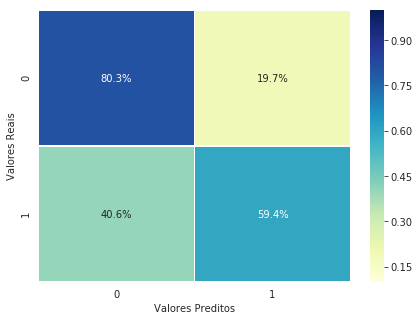

In [0]:
plotResults('SVM - OHE Binned', predictions1, y_valid)

SVM - OHE Not Binned
Accuracy: 77.63%
F1 Score: 52.65%
Balanced Accuracy: 69.98%



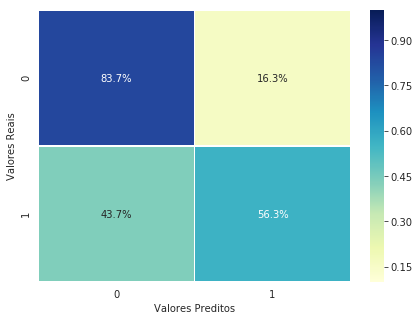

In [0]:
plotResults('SVM - OHE Not Binned', predictions2, y_valid)

In [0]:
cols3=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','AGE_GROUP']
defCols=['LIMIT_BAL','EDUCATION','PSCORE','PAY_AMT1','PAY_AMT6']

encoder3 = ColumnTransformer([
    ('num', StandardScaler(), ['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT6','PSCORE']),
    ('cat', OneHotEncoder(handle_unknown='ignore', categories='auto',sparse=False,), ['EDUCATION','AGE_GROUP','PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
])

e3_train = encoder3.fit_transform(fx_train[cols3+defCols])
e3_valid = encoder3.transform(fx_valid[cols3+defCols])

In [0]:
%%time

svm3 = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced', random_state=777)
svm3.fit(e3_train, y_train)
predictions3 = svm3.predict(e3_valid)

CPU times: user 1min 37s, sys: 63.3 ms, total: 1min 37s
Wall time: 1min 37s


SVM - OHE Age Binned
Accuracy: 77.60%
F1 Score: 52.54%
Balanced Accuracy: 69.90%



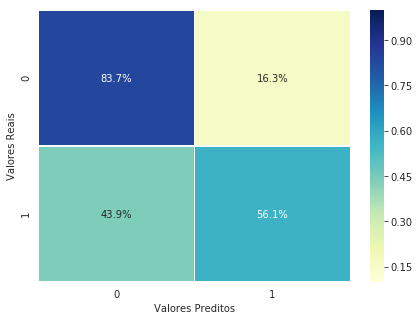

In [0]:
plotResults('SVM - OHE Age Binned', predictions3, y_valid)

## Classificadores avançados



### Teste do classificador XGB

In [0]:
model = XGBClassifier()
model.fit(enb_train, y_train)

predictions = model.predict(enb_valid)

XGB - OHE not binned
Accuracy: 82.00%
F1 Score: 46.85%
Balanced Accuracy: 65.49%



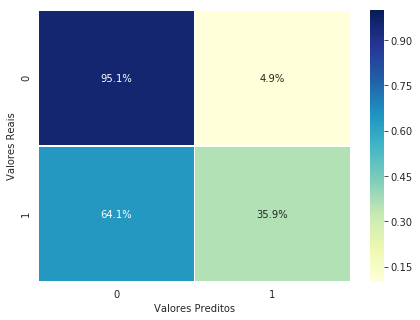

In [0]:
plotResults('XGB - OHE not binned', predictions, y_valid)

In [0]:
model2 = XGBClassifier()
model2.fit(eb_train, y_train)

predictions = model2.predict(eb_valid)

XGB - OHE Binned
Accuracy: 81.30%
F1 Score: 46.01%
Balanced Accuracy: 65.09%



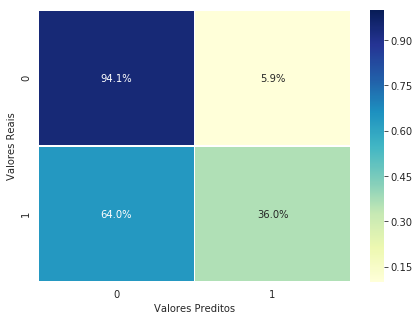

In [0]:
plotResults('XGB - OHE Binned', predictions, y_valid)

In [0]:
smoterX = SMOTE(sampling_strategy = 'minority', random_state=71717)
sz_train, sy_train = smoterX.fit_resample(enb_train, y_train)

modelS = XGBClassifier()
modelS.fit(sz_train, sy_train)

predictions = modelS.predict(enb_valid)

XGBoost - SMOTE-d
Accuracy: 78.70%
F1 Score: 52.49%
Balanced Accuracy: 69.58%



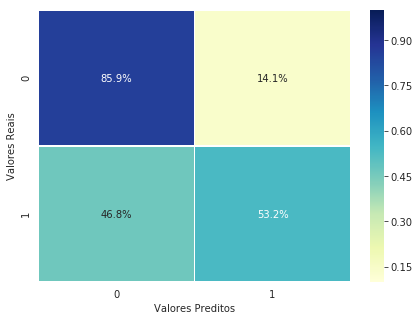

In [0]:
plotResults('XGBoost - SMOTE-d', predictions, y_valid)

Grid search pelos melhores valores para os hiperparâmetros do SVM foi feita em notebook local, por conta do tempo que levou (por volta de 18h).

In [0]:

# params2Test = {
#     'C': [0.001, 0.01, 0.1, 1, 10],
#     'gamma': [0.001, 0.01, 0.1, 1, 10], #auto equivale a 0.043
#     'kernel': ['linear', 'rbf'],
#     'class_weight': [None, 'balanced']
# }


# grid = GridSearchCV(SVC(), params2Test, scoring='balanced_accuracy', cv=5)
# grid.fit(z_train, y_train)

In [0]:
svmGrid = SVC(kernel='rbf', C=10, gamma='auto', class_weight='balanced', random_state=444)
svmGrid.fit(mz_train, y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=444, shrinking=True, tol=0.001,
    verbose=False)

SVM - Grid
Accuracy: 76.40%
F1 Score: 52.48%
Balanced Accuracy: 70.16%



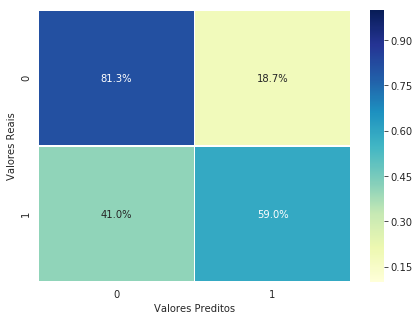

In [0]:
predictions = svmGrid.predict(mz_valid)
plotResults('SVM - Grid', predictions, y_valid)

### LSTM

Até o momento, nosso melhor resultado foi com um SVM em cima de um conjunto reduzido de features, sem encoding das features categóricas. Iremos testar agora uma rede LSTM no mesmo conjunto, para que possamos comparar o desempenho:

In [0]:
lx_train = x_train.copy()
lx_train.reset_index(inplace=True)


LX_train = pd.wide_to_long(lx_train, stubnames=['PAY_','BILL_AMT','PAY_AMT'], sep='', i='index', j='month')\
  .sort_values(by=['index','month'], ascending=[True, False])\
  .reset_index(drop=True)
  
LX_train.head(12)

,EDUCATION,AGE,LIMIT_BAL,SEX,MARRIAGE,PAY_,BILL_AMT,PAY_AMT
0,2,24,20000.0,2,1,-2,0.0,0.0
1,2,24,20000.0,2,1,-2,0.0,0.0
2,2,24,20000.0,2,1,-1,0.0,0.0
3,2,24,20000.0,2,1,-1,689.0,0.0
4,2,24,20000.0,2,1,2,3102.0,689.0
5,2,24,20000.0,2,1,2,3913.0,0.0
6,2,26,120000.0,2,2,2,3261.0,2000.0
7,2,26,120000.0,2,2,0,3455.0,0.0
8,2,26,120000.0,2,2,0,3272.0,1000.0
9,2,26,120000.0,2,2,0,2682.0,1000.0


In [0]:
x_train[np.logical_and(
    x_train.LIMIT_BAL==20000, 
    x_train.AGE==24) &
    np.logical_and(x_train.BILL_AMT3==689.0,
    x_train.MARRIAGE==1
)].head(5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0


OK, ordem confirmada. Momento de rodar o melt na validação e o reshape.

In [0]:
lx_valid= x_valid.copy()
lx_valid.reset_index(inplace=True)


LX_valid = pd.wide_to_long(lx_valid, stubnames=['PAY_','BILL_AMT','PAY_AMT'], sep='', i='index', j='month')\
  .sort_values(by=['index','month'], ascending=[True, False])\
  .reset_index(drop=True)

In [0]:
scaler2 = StandardScaler()

lz_train = scaler2.fit_transform(LX_train)
lz_valid = scaler2.transform(LX_valid)

In [0]:
LZ_train = np.reshape(lz_train, (x_train.shape[0], 6, 8))
LZ_valid = np.reshape(lz_valid, (x_valid.shape[0], 6, 8))

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

lFactor=0.1

fLSTM = Sequential()
fLSTM.add(LSTM(32, input_shape=(6, 8), dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(lFactor), recurrent_regularizer=l2(lFactor), bias_regularizer=l2(lFactor)))
fLSTM.add(Dense(8, activation='sigmoid'))
fLSTM.add(Dense(1, activation='sigmoid'))
fLSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
fLSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
_________________________________________________________________


In [0]:
fLSTM.fit(LZ_train, y_train, validation_data=(LZ_valid, y_valid), batch_size=24, epochs=7, class_weight=class_weights)
predictions = fLSTM.predict_classes(LZ_valid)

Train on 24000 samples, validate on 3000 samples
Epoch 1/7
24000/24000 [==============================] - 8s 334us/step - loss: 0.6959 - binary_accuracy: 0.5232 - val_loss: 0.6982 - val_binary_accuracy: 0.4870
Epoch 2/7
24000/24000 [==============================] - 5s 227us/step - loss: 0.6955 - binary_accuracy: 0.5164 - val_loss: 0.6944 - val_binary_accuracy: 0.4937
Epoch 3/7
24000/24000 [==============================] - 6s 230us/step - loss: 0.6951 - binary_accuracy: 0.4948 - val_loss: 0.6900 - val_binary_accuracy: 0.4923
Epoch 4/7
24000/24000 [==============================] - 6s 231us/step - loss: 0.6944 - binary_accuracy: 0.5301 - val_loss: 0.6933 - val_binary_accuracy: 0.5090
Epoch 5/7
24000/24000 [==============================] - 5s 224us/step - loss: 0.6944 - binary_accuracy: 0.5150 - val_loss: 0.6768 - val_binary_accuracy: 0.7033
Epoch 6/7
24000/24000 [==============================] - 6s 233us/step - loss: 0.6943 - binary_accuracy: 0.5405 - val_loss: 0.7157 - val_binary_ac

LSTM
Accuracy: 65.57%
F1 Score: 19.23%
Balanced Accuracy: 48.73%



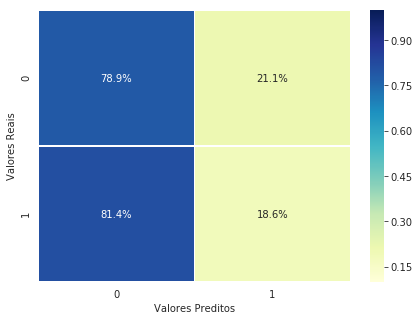

In [0]:
plotResults('LSTM', predictions, y_valid)

In [0]:
fSmoter = SMOTE(sampling_strategy = 'minority', random_state=71717)
sz_train, sy_train = fSmoter.fit_resample(x_train, y_train)

sz_train=pd.DataFrame(sz_train)
sz_train.columns = x_train.columns

In [0]:
lx_train = sz_train
lx_train.reset_index(inplace=True)

LX_train = pd.wide_to_long(lx_train, stubnames=['PAY_','BILL_AMT','PAY_AMT'], sep='', i='index', j='month')\
  .sort_values(by=['index','month'], ascending=[True, False])\
  .reset_index(drop=True)



scalerL = StandardScaler()
lz_train = scaler2.fit_transform(LX_train)

LZ_train = np.reshape(lz_train, (lx_train.shape[0], 6, 8))

In [0]:
from keras.regularizers import l2

lFactor=10

fLSTM = Sequential()
fLSTM.add(LSTM(32, input_shape=(6, 8), dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(lFactor), recurrent_regularizer=l2(lFactor), bias_regularizer=l2(lFactor)))
fLSTM.add(Dense(1, activation='sigmoid'))
fLSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
fLSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
fLSTM.fit(LZ_train, sy_train, validation_data=(LZ_valid, y_valid), batch_size=24, epochs=7)
predictions = fLSTM.predict_classes(LZ_valid)

Train on 37382 samples, validate on 3000 samples
Epoch 1/7
37382/37382 [==============================] - 12s 330us/step - loss: 82.0261 - binary_accuracy: 0.5761 - val_loss: 0.7128 - val_binary_accuracy: 0.4930
Epoch 2/7
37382/37382 [==============================] - 9s 227us/step - loss: 0.7010 - binary_accuracy: 0.5883 - val_loss: 0.7345 - val_binary_accuracy: 0.4313
Epoch 3/7
37382/37382 [==============================] - 9s 230us/step - loss: 0.6963 - binary_accuracy: 0.5913 - val_loss: 0.7210 - val_binary_accuracy: 0.5297
Epoch 4/7
37382/37382 [==============================] - 8s 222us/step - loss: 0.6939 - binary_accuracy: 0.5900 - val_loss: 0.7124 - val_binary_accuracy: 0.5333
Epoch 5/7
37382/37382 [==============================] - 8s 226us/step - loss: 0.6938 - binary_accuracy: 0.5911 - val_loss: 0.7363 - val_binary_accuracy: 0.4787
Epoch 6/7
37382/37382 [==============================] - 9s 229us/step - loss: 0.6923 - binary_accuracy: 0.5925 - val_loss: 0.7274 - val_binary_

LSTM + Smote
Accuracy: 48.97%
F1 Score: 32.70%
Balanced Accuracy: 51.52%



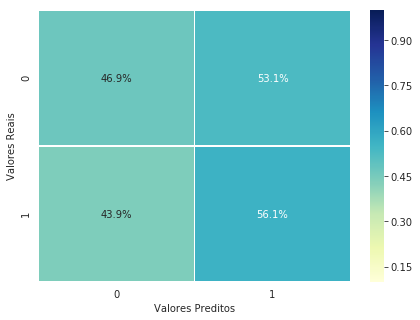

In [0]:
plotResults('LSTM + Smote', predictions, y_valid)

### Voting Classifier

Nosso melhor classificador até o momento foi o SVM em cima do DataSet reduzido, com um score F1 de 53.33%. Iremos criar um classificador de cada tipo testado neste conjunto e juntá-los para analisar o resultado.

In [0]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('svm', SVC(kernel='rbf', C=1, class_weight='balanced', random_state=979979)),
    ('logisticregression', LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced')),
    ('gbm', GradientBoostingClassifier()),
    ('xgb', XGBClassifier())
]

clf = VotingClassifier(classifiers, n_jobs=-1)

In [0]:
scalerV = StandardScaler()

fz_train = scalerV.fit_transform(fx_train)
fz_valid = scalerV.transform(fx_valid)

smoterV = SMOTE(sampling_strategy = 'minority', random_state=71717)
sz_train, sy_train = smoterV.fit_resample(fz_train, y_train)

In [0]:
_=clf.fit(sz_train, sy_train)

Voting Classifier
Accuracy: 79.67%
F1 Score: 52.27%
Balanced Accuracy: 69.18%



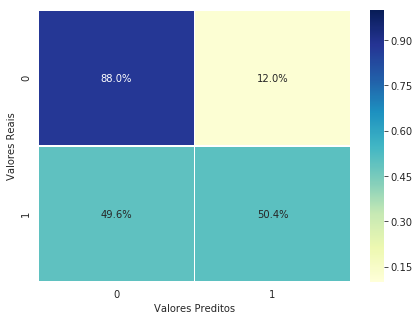

In [0]:
predictions = clf.predict(fz_valid)
plotResults('Voting Classifier', predictions, y_valid)

## Conclusão

Como nosso classificador ainda continua sendo o SVM Redux (por muito pouco) pelas métricas de Acurácia Balanceada e F1, iremos utilizá-lo para fazer a predição no teste.

In [0]:
x_train_final = fx_train.append(fx_valid, ignore_index=True)
y_train_final = y_train.append(y_valid, ignore_index=True)

fx_test = x_test[fx_train.columns]


scalerFinal=StandardScaler()
z_train_final = scalerFinal.fit_transform(x_train_final)
z_test = scalerFinal.transform(fx_test)

SVM - FINAL
Accuracy: 78.27%
F1 Score: 54.60%
Balanced Accuracy: 71.38%



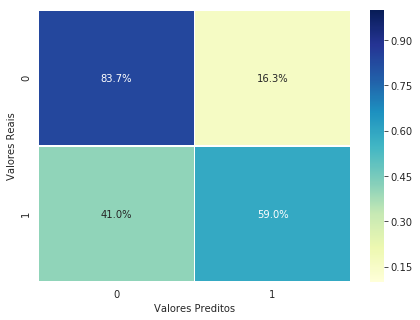

In [0]:
svmFinal = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=979979)
svmFinal.fit(z_train_final, y_train_final)

predictions = svmFinal.predict(z_test)

plotResults('SVM - FINAL', predictions, y_test)